# Model-guided design of regulatory elements

In [1]:
import anndata
import numpy as np
import pandas as pd
import os
import importlib

%matplotlib inline

## Load the pre-trained Catlas model from the model zoo

This is a binary classification model trained on snATAC-seq data from Catlas (http://catlas.org/humanenhancer/)

In [2]:
import grelu.resources
model = grelu.resources.load_model(project='human-atac-catlas', model_name="tutorial_model")

/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: lal-avantika (grelu). Use `wandb login --relogin` to force relogin
wandb: Downloading large artifact tutorial_model:latest, 1187.53MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:2.5
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:2.1


## View the model's metadata

`model.data_params` is a dictionary containing metadata about the data used to train the model. Let's look at what information is stored:

In [4]:
for key in model.data_params.keys():
    if key !="tasks":
        print(key, model.data_params[key])

train_n_seqs 982845
val_n_seqs 55832
train_seq_len 200
val_seq_len 200
train_rc True
val_rc False
train_max_shift 0
val_max_shift 0
train_max_offset 3
val_max_offset 0
train_n_augmented 14
val_n_augmented 1
train_chroms ['chr1', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr20', 'chr21', 'chr22', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9']
val_chroms ['chr10']


Note the parameter `train_seq_len`. This tells us that the model was trained on 200 bp long sequences.

`model.data_params['tasks']` is a large dictionary containing metadata about the output tracks that the model predicts. We can collect these into a dataframe called tasks:

In [5]:
tasks = pd.DataFrame(model.data_params["tasks"])
tasks.head()

,name
0,Follicular
1,Fibro General
2,Acinar
3,T Lymphocyte 1 (CD8+)
4,T lymphocyte 2 (CD4+)


## Generate a random starting sequence

In [6]:
import grelu.sequence.utils
start_seq = grelu.sequence.utils.generate_random_sequences(
    n=1, # number of sequences to generate
    seq_len=model.data_params['train_seq_len'],
    seed=0,
    output_format="strings"
)
start_seq

['ATCATTTTCTCGATGAAAGCGTTGACCCCACATATCGTTAGTACTCTTGTACCCTATGATTGTGTAGAAACCGAACTACGGTACCTCCTGTTGGTAGTCACGATAGATTATAAAAGTATGTTCCCACCCTATCGACGAGACTGGCATCCTAGGTGTTTGCGGTGTTGGTACGTGCGCAGGTATGTAAGAGTGGTAAACGA']

## Create the objective to optimize - predictions in microglia

In the first example, we want to create a sequence that has a high probability of accessibility in microglia (regardless of what it does in other cell types). We first must define the objective that we want to optimize. Such objective functions are defined in `grelu.transforms.prediction_transforms`. We pick the `Aggregate` class, which tells the model to aggregate predictions over a subset of output tasks or positions.

In [7]:
from grelu.transforms.prediction_transforms import Aggregate

microglia_score = Aggregate(
    tasks = ["Microglia"],
    model = model,
)

## Run directed evolution to maximize the prediction in microglia, ignoring other cell types

`grelu.design` contains algorithms for model-guided sequence design. We pick the `evolve` function, which performs directed evolution. Note that it selects the sequence with the highest objective function value at every iteration, which in this case is the highest predicted accessibility in microglia. If you wanted to instead select the sequence with the lowest prediction in microglia, you could add `weight=-1` to the `Aggregate` object.

In [9]:
import grelu.design

output = grelu.design.evolve(
    start_seq, # The initial sequences
    model, 
    prediction_transform=microglia_score, # Objective to optimize 
    max_iter=5, # Number of iterations for directed evolution
    num_workers=8,
    devices=1,
    return_seqs="all", # Return all the evolved sequences
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Iteration 0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  0.46it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best value at iteration 0: 0.336
Iteration 1
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 45.44it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best value at iteration 1: 0.511
Iteration 2
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 89.66it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best value at iteration 2: 0.784
Iteration 3
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 90.12it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best value at iteration 3: 0.914
Iteration 4
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 90.16it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best value at iteration 4: 0.949
Iteration 5
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 89.40it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best value at iteration 5: 0.969
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 90.63it/s]


## View output

The output of `grelu.design.evolve` is a dataframe which contains all the sequences generated during directed evolution, and the model's predictions. Let's look at these:

In [11]:
output.head()

,iter,start_seq,best_in_iter,prediction_score,seq_score,total_score,seq,position,allele,Microglia
0,0,0,True,0.336071,0,0.336071,ATCATTTTCTCGATGAAAGCGTTGACCCCACATATCGTTAGTACTC...,NaN,NaN,0.336154
1,1,0,False,0.328587,0,0.328587,CTCATTTTCTCGATGAAAGCGTTGACCCCACATATCGTTAGTACTC...,0.0,C,0.328587
2,1,0,False,0.331385,0,0.331385,GTCATTTTCTCGATGAAAGCGTTGACCCCACATATCGTTAGTACTC...,0.0,G,0.331385
3,1,0,False,0.326592,0,0.326592,TTCATTTTCTCGATGAAAGCGTTGACCCCACATATCGTTAGTACTC...,0.0,T,0.326592
4,1,0,False,0.320363,0,0.320363,AACATTTTCTCGATGAAAGCGTTGACCCCACATATCGTTAGTACTC...,1.0,A,0.320363


We can visualize the model's predictions on the sequences generated at each iteration:

/usr/local/lib/python3.11/dist-packages/plotnine/themes/themeable.py:2398: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


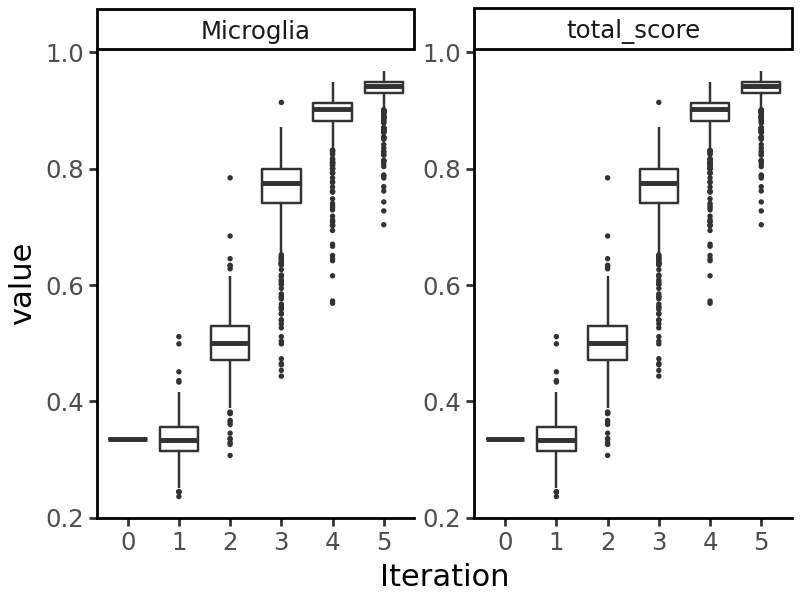

In [12]:
import grelu.visualize
grelu.visualize.plot_evolution(output, outlier_size=.1)

We see that the predicted probability of accessibility in Microglia increases at each iteration.

## Examine the best sequence

Let us take the best sequence from the final iteration (iteration 5):

In [13]:
end_seq = output[output.iter==5].sort_values('total_score').iloc[-1].seq
end_seq

'ATCATTTTCTCGATGAAAGCGTTGACCCCACATATCGTTAGTACTCTTGTACCCTATGATTGGGTAGAAACCGAACTACGGTACTTCCTGTTGGTAGTCACGATAGATTATAAAAGTATGTTCCCGCCCTATCGACGAGACTGGCATCCTAGGTGTTTCCGGTGTTGGTACGTGCGCACGTATGTAAGAGTGGTAAACGA'

We can compare this to the sequence we started with:

In [14]:
import grelu.sequence.mutate
mutated_positions = grelu.sequence.mutate.seq_differences(start_seq[0], end_seq, verbose=True)

Position: 62 Reference base: T Alternate base: G Reference sequence: GATTGTGTAG
Position: 84 Reference base: C Alternate base: T Reference sequence: GGTACCTCCT
Position: 125 Reference base: A Alternate base: G Reference sequence: TTCCCACCCT
Position: 158 Reference base: G Alternate base: C Reference sequence: TGTTTGCGGT
Position: 178 Reference base: G Alternate base: C Reference sequence: GCGCAGGTAT


## Visualize importance scores for the start and end sequence

In [16]:
import grelu.interpret.score

start_attrs = grelu.interpret.score.get_attributions(
    model, start_seq, prediction_transform=microglia_score, device=0,
)
end_attrs = grelu.interpret.score.get_attributions(
    model, end_seq, prediction_transform=microglia_score, device=0,
)

In [17]:
seq='CAAAGATATATGTCATAATAATTATCTTTTCACTTTCTTTGTTAGGGACCAGGAATGATAAACCACTTAGTCATTTTTTAGGTTTACAAGAACTTAAGGGGAACTAAGAAAGGAACCCTTACTCCTGAACTCTCAGCCTCATCTGTGCTGGACCATTCTAACTTTGTACCCTTTCATGAGATTGATATAATTTAGAAAAT'
print(model.cpu().eval()(seq)[0, 62, 0])

tensor(0.0662, grad_fn=<SelectBackward0>)


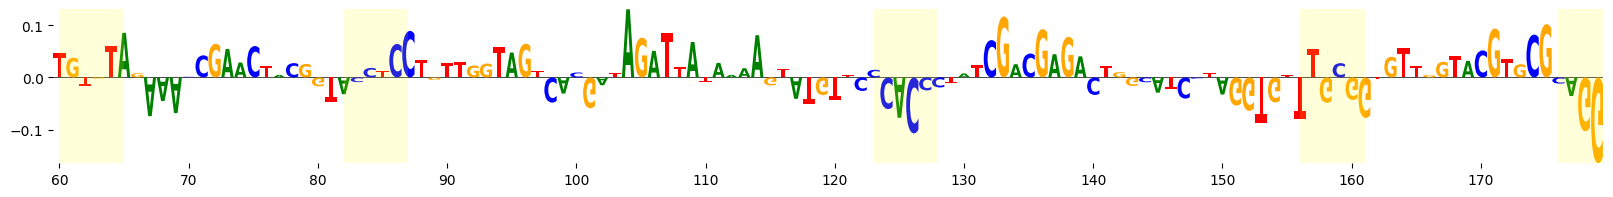

In [18]:
grelu.visualize.plot_attributions(
    start_attrs, start_pos=60, end_pos=180,
    highlight_centers=mutated_positions, highlight_width=5, ticks=10)

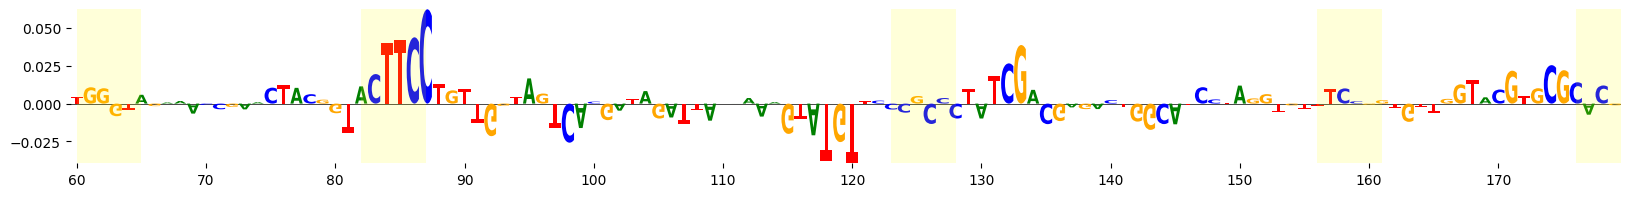

In [19]:
grelu.visualize.plot_attributions(
    end_attrs, start_pos=60, end_pos=180,
    highlight_centers=mutated_positions, highlight_width=5, ticks=10)

## Starting with real genomic sequences

In [21]:
# Load dataset used to train the model
artifact = grelu.resources.get_artifact(project='human-atac-catlas', name='dataset').download()
ad = anndata.read_h5ad(artifact + '/catlas-binary-pseudobulk.h5ad') 

wandb: Downloading large artifact dataset:latest, 57.88MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.2


In [22]:
# Sample some starting sequences from the test set
test_intervals = ad.var[~ad.var.chrom.isin(model.data_params['train_chroms'] + model.data_params['val_chroms'])] 
start_intervals = test_intervals.sample(100) 
start_intervals.head()

,chrom,start,end,class,present_in_fetal,present_in_adult,cre_ID,width
200701,chr11,113277513,113277913,Distal,yes,no,95,400
1127378,chrX,19852633,19853033,Distal,yes,yes,137,400
1133895,chrX,46837379,46837779,Promoter Proximal,yes,yes,2,400
161573,chr11,12169806,12170206,Distal,yes,yes,38,400
202707,chr11,117188720,117189120,Distal,yes,yes,20,400


## Optimize for cell-type specific accessibility in microglia

We now want to optimize a more complicated objective. We want to create sequences that have a high probability of accessibility in microglia but low probability of accessibility in neurons. We begin by identifying neuron-related cell types in the model's output:

In [24]:
neuron_tasks = tasks.name[tasks.name.str.contains("Neuron")]
print(neuron_tasks)

51                 Enteric Neuron
109     Fetal Excitatory Neuron 3
110     Fetal Excitatory Neuron 4
111     Fetal Excitatory Neuron 5
112     Fetal Excitatory Neuron 6
113     Fetal Excitatory Neuron 7
114     Fetal Excitatory Neuron 8
125          Fetal Adrenal Neuron
145          Fetal Retinal Neuron
146          Fetal Enteric Neuron
148        Fetal Placental Neuron
164     Fetal Inhibitory Neuron 1
165     Fetal Inhibitory Neuron 2
166     Fetal Excitatory Neuron 9
167    Fetal Excitatory Neuron 10
201     Fetal Excitatory Neuron 1
202     Fetal Excitatory Neuron 2
Name: name, dtype: object


We now define our objective using the `Specificity` class of transforms. This class takes the model's predictions and calculates a score by comparing predictions in defined on-target tasks (in this case Microglia) and off-target tasks (in this case, neurons). We can also specify a relative weight for the off-target tasks, how to aggregate the on- and off-target predictions, and soft thresholds for off-target expression.

In [25]:
from grelu.transforms.prediction_transforms import Specificity

mcg_specificity = Specificity(
    on_tasks = "Microglia", # We want high predictions in these
    off_tasks = neuron_tasks, # We want low predictions in these
    on_aggfunc = "mean", 
    off_aggfunc = "max", # Compare the on-target prediction to the highest prediction in any off-target task.
    model=model,
    compare_func="divide", # Each sequence will get a score which is the ratio of the on-target and off-target scores
)

In [26]:
output = grelu.design.evolve(
    start_intervals, # Start from the natural sequences
    model, 
    genome="hg38",
    prediction_transform=mcg_specificity, # Optimize the specific accessibility score
    max_iter=5,
    num_workers=8,
    devices=1,
    return_seqs="all",
    for_each=False,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Iteration 0
Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.25it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best value at iteration 0: 2.407
Iteration 1
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 26.19it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best value at iteration 1: 11.090
Iteration 2
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 79.10it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best value at iteration 2: 18.181
Iteration 3
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 71.38it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best value at iteration 3: 24.515
Iteration 4
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 69.87it/s]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Best value at iteration 4: 27.889
Iteration 5
Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 72.01it/s]
Best value at iteration 5: 33.514


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|████████████████████████████████████████████████████████████████████████████████████| 96/96 [00:01<00:00, 61.66it/s]


## Examine the output

In [27]:
output.head()

,iter,start_seq,best_in_iter,prediction_score,seq_score,total_score,seq,position,allele,Microglia,...,Fetal Adrenal Neuron,Fetal Retinal Neuron,Fetal Enteric Neuron,Fetal Placental Neuron,Fetal Inhibitory Neuron 1,Fetal Inhibitory Neuron 2,Fetal Excitatory Neuron 9,Fetal Excitatory Neuron 10,Fetal Excitatory Neuron 1,Fetal Excitatory Neuron 2
0,0,0,False,0.256575,0,0.256575,CGGGAGGGCCCAGCAGTGAGGGGCAGGCTCTTCTGGTCACCAGGCT...,NaN,NaN,0.019866,...,0.077428,0.045955,0.040389,0.020773,0.049155,0.032505,0.070389,0.051169,0.065171,0.045581
1,0,1,False,0.024389,0,0.024389,CAGAAAAAAAAAAAAAAAAAAAAATCCACGAACATACCCAATTGCA...,NaN,NaN,0.009538,...,0.391089,0.039132,0.017830,0.005659,0.014585,0.036323,0.018639,0.007456,0.019771,0.017324
2,0,2,False,0.482529,0,0.482529,AGAGGCCGCCCAGAGGGCTGTGGAGCTCCGGAAGGAGCCTTAGGAG...,NaN,NaN,0.376673,...,0.726585,0.757391,0.695120,0.547252,0.747407,0.488613,0.708807,0.622864,0.780623,0.598827
3,0,3,False,0.201881,0,0.201881,CTACATTTAAAAATTATAGGCATTGTCAGATTCTCCTCCCTGGAGT...,NaN,NaN,0.031374,...,0.155406,0.079447,0.035455,0.020622,0.052473,0.058265,0.059634,0.035162,0.063607,0.033670
4,0,4,False,0.221412,0,0.221412,ACCTGTAGGTACTCGGCCCCGAGTGGACTCCATGAGCTCTGTGGAG...,NaN,NaN,0.070284,...,0.317437,0.178693,0.130142,0.063610,0.094351,0.039035,0.124502,0.067830,0.178347,0.062247


Let's look at the best sequence in our starting set (iteration 0)

In [28]:
start = output[output.iter==0].sort_values('total_score').iloc[-1]
start

iter                                                                          0
start_seq                                                                    34
best_in_iter                                                               True
prediction_score                                                       2.406896
seq_score                                                                     0
total_score                                                            2.406896
seq                           CTCTGGTCCTCAAGTGATCCGCCCACCTCGGCTTTCCAAAGTGCTG...
position                                                                    NaN
allele                                                                      NaN
Microglia                                                              0.134673
Enteric Neuron                                                         0.055953
Fetal Excitatory Neuron 3                                              0.022552
Fetal Excitatory Neuron 4               

And the best sequence in our final set (iteration 5)

In [29]:
# Examine the best final sequence
end = output[output.iter==5].sort_values('total_score').iloc[-1]
end

iter                                                                          5
start_seq                                                                    34
best_in_iter                                                               True
prediction_score                                                      33.514305
seq_score                                                                     0
total_score                                                           33.514305
seq                           CTCTGGTCCTCAAGTGATCCGCCCACCTCGGCTTTCCAAAGTGCTG...
position                                                                  300.0
allele                                                                        A
Microglia                                                              0.545757
Enteric Neuron                                                         0.014724
Fetal Excitatory Neuron 3                                              0.008562
Fetal Excitatory Neuron 4               

We can plot the accessibility of the sequences at each iteration:

/usr/local/lib/python3.11/dist-packages/plotnine/themes/themeable.py:2398: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


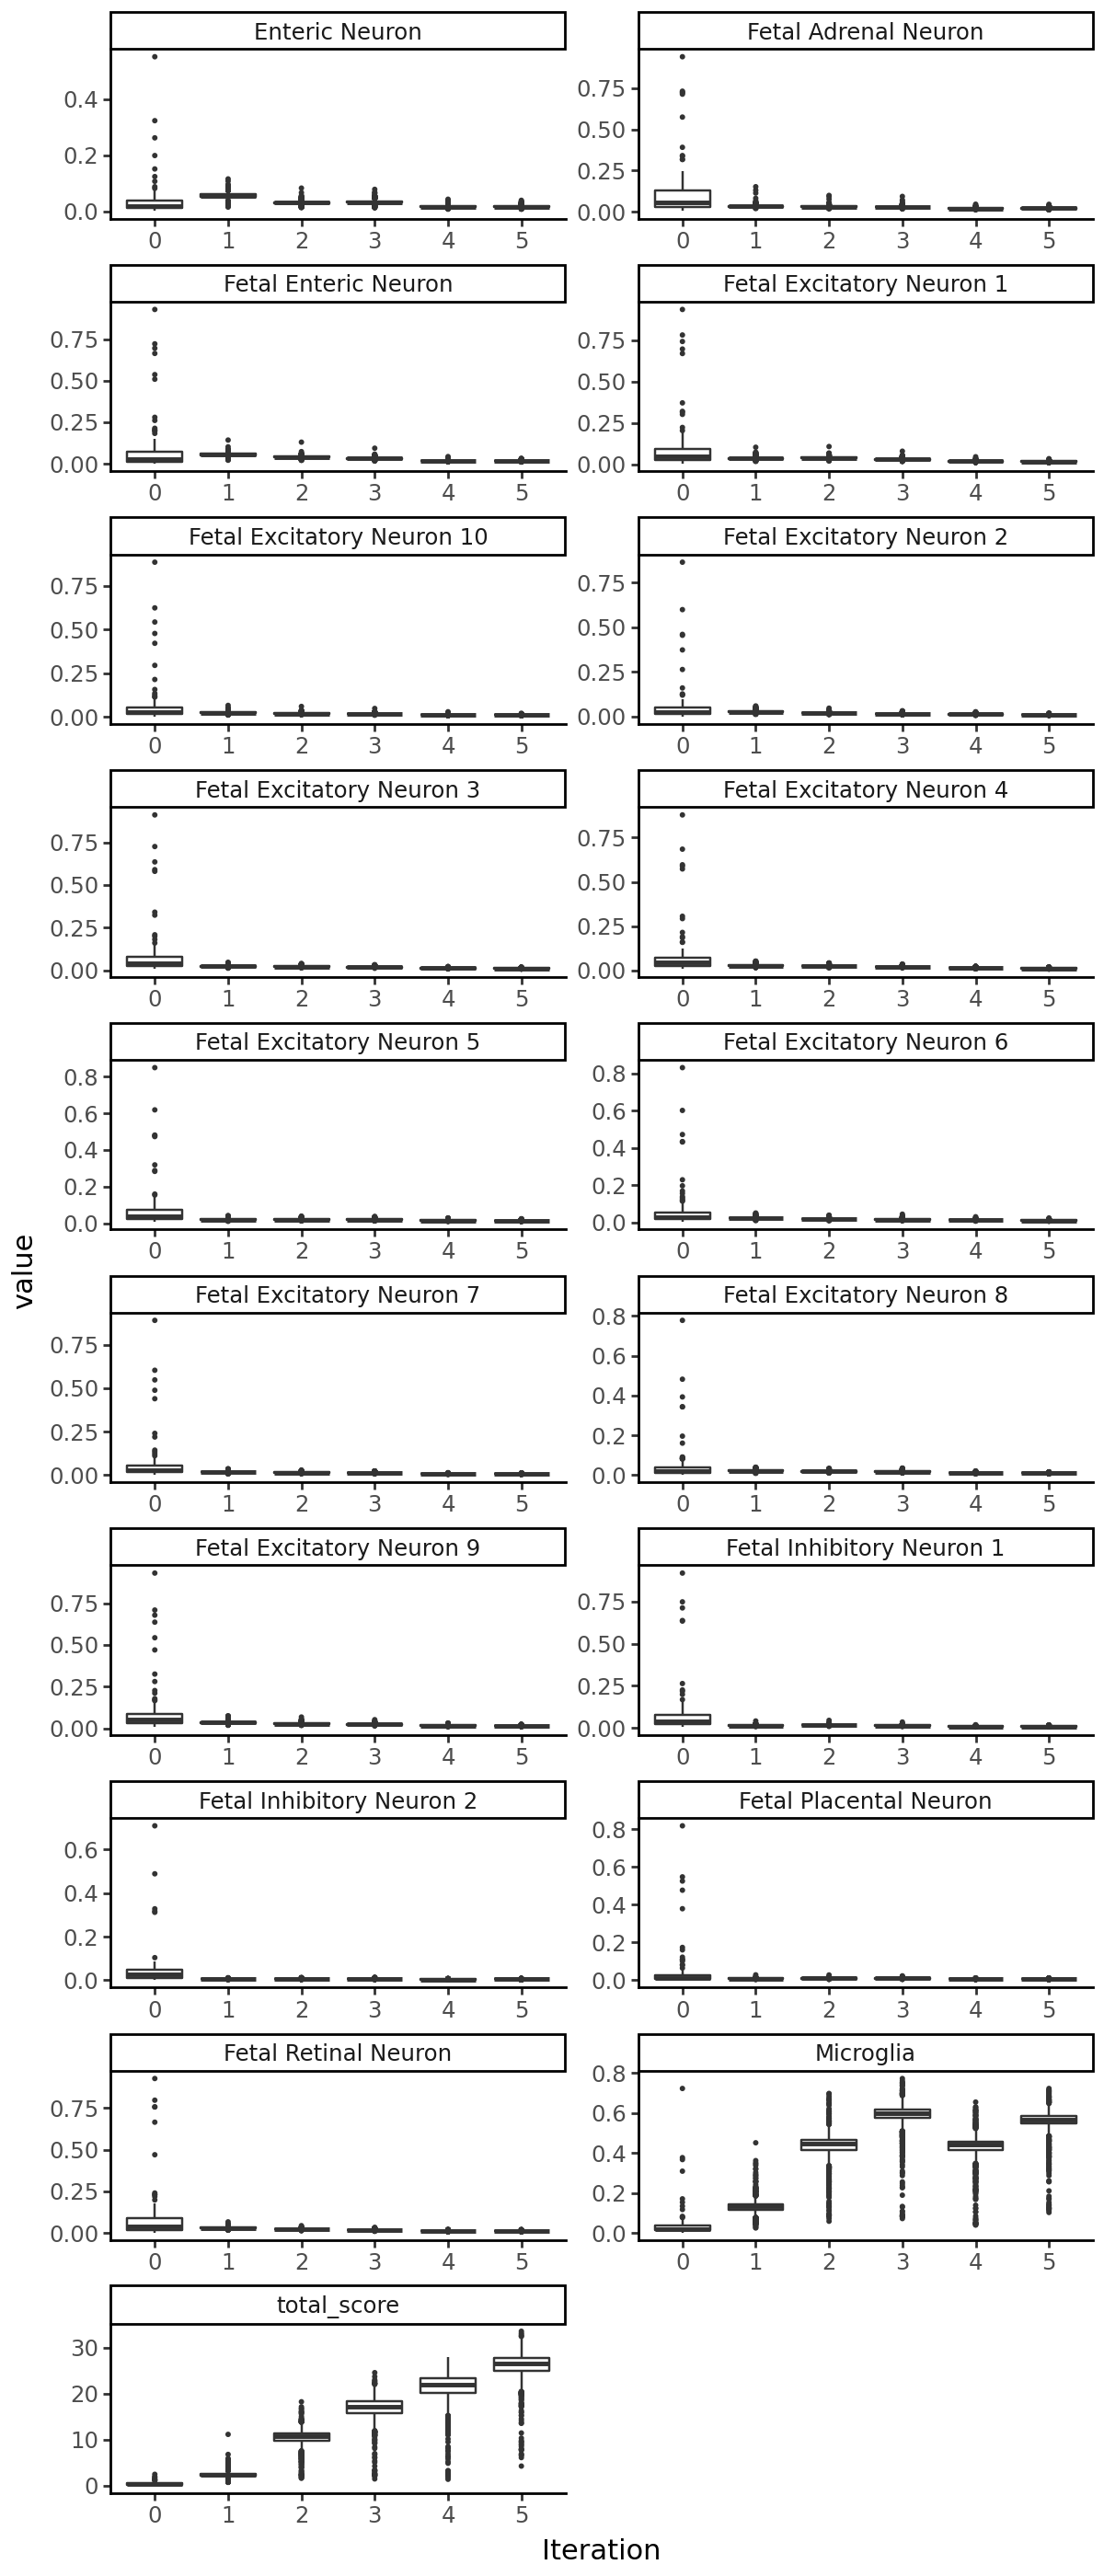

In [30]:
grelu.visualize.plot_evolution(output, figsize=(6, 14), outlier_size=0.2)